<h4><b>Load Libraries</b></h4>

In [25]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import yfinance as yf

<h4><b>Import Data</b></h4>
<p>The 1-day(daily) OHLCV data of EURUSD price is stored in a Yahoo Finance API. The data ranges from January 2004 to today.</p>

In [26]:
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)


class Statistics(object):
    def __init__(self, symbol, time_frame):
        self.symbol = symbol
        self.time_frame = time_frame
        self.data = self.load_data()

    # Load data
    def load_data(self):
        ticket = yf.Ticker(f"{self.symbol}")
        dataset = ticket.history(period="max", interval=self.time_frame, auto_adjust=True).drop(columns=["Volume", "Dividends", "Stock Splits"]).rename(
            columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close'})  # periods: “1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”
        dataset["time"] = dataset.index
        self.data = dataset
        return pd.DataFrame(self.data)

    def feature_engeering(self):
        dataset = self.load_data()
        dataset["amplitude"] = (dataset["high"].rolling(3).max() - dataset["low"].rolling(3).min())
        dataset["daily_return"] = dataset["close"].pct_change(periods=1)
        dataset["hour"] = dataset["time"].dt.hour
        dataset["day"] = dataset["time"].dt.day
        dataset["dayofweek"] = dataset["time"].dt.dayofweek
        dataset["dayname"] = dataset["time"].dt.day_name()
        dataset["weekday"] = dataset["time"].dt.weekday
        dataset["dayofyear"] = dataset["time"].dt.dayofyear # Monday=0, Sunday=6.
        dataset["month"] = dataset["time"].dt.month
        dataset["mean_month"] = dataset["close"].rolling(window=30).mean()
        dataset["positive_negative"] = np.select([dataset["daily_return"] >= 0, dataset["daily_return"] < 0], [1, -1])
        dataset["above_below_mean"] = np.select([dataset["close"] > dataset["close"].rolling(window=30).mean(), dataset["daily_return"] < dataset["close"].rolling(window=30).mean()], [1, -1])
        dataset["volatility"] = dataset["daily_return"].rolling(window=252).std() * np.sqrt(252)
        return pd.DataFrame(dataset).dropna()


symbols = ["EURUSD=X"]
time_frames = ['1d']
for symbol in symbols:
    print(f'\n {symbol}')
    for time_frame in time_frames:
        strategytester = Statistics(symbol, time_frame)
        dataset = strategytester.feature_engeering()
        print(dataset)



 EURUSD=X
                open      high       low     close       time  amplitude  \
Date                                                                       
2004-11-18  1.303798  1.307292  1.294398  1.294901 2004-11-18   0.014985   
2004-11-19  1.294800  1.306404  1.294197  1.303900 2004-11-19   0.013095   
2004-11-22  1.302592  1.305193  1.301693  1.304002 2004-11-22   0.013095   
2004-11-23  1.304206  1.310307  1.297993  1.309706 2004-11-23   0.016110   
2004-11-24  1.309998  1.319105  1.308695  1.317801 2004-11-24   0.021111   
...              ...       ...       ...       ...        ...        ...   
2022-10-19  0.986388  0.986699  0.976019  0.986388 2022-10-19   0.014911   
2022-10-20  0.976648  0.984514  0.975553  0.976648 2022-10-20   0.011809   
2022-10-21  0.977890  0.985698  0.970732  0.977890 2022-10-21   0.015967   
2022-10-24  0.986009  0.988963  0.980892  0.986009 2022-10-24   0.018231   
2022-10-25  0.987264  0.997904  0.985416  0.996810 2022-10-25   0.027172   



<h4><b>The Probability Function</h4></b>
<p>I’ll put the code in a function that takes a Boolean Series and returns a probability.

<h4><b>Laws of Probability</h4></b>
<li>Theorem 1: Using a conjunction to compute a conditional probability.</li>
<li>Theorem 2: Using a conditional probability to compute a conjunction.</li>
<li>Theorem 3: Using conditional(A, B) to compute conditional(B, A).</li>

0.5020425714900022
50.20425714900022 % are positive.

0.3339066867340357
33.39066867340357 % are high volatility.

0.16706084712964953
16.70608471296495 % are positive and high volatility.



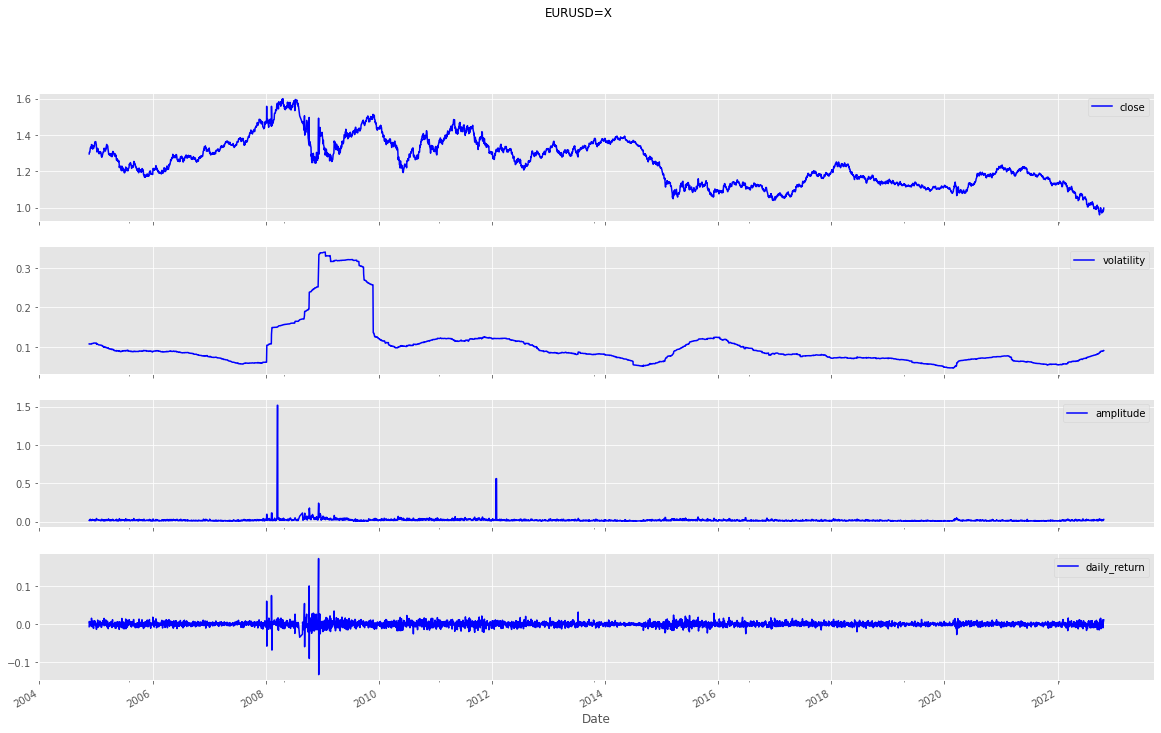

In [27]:
# Probability
def probability(x):
    return x.mean()

# Conditional Probability
def conditional_probability(proposition, given):
    return probability(proposition[given])

# Positive daily return
positive = (dataset["positive_negative"] == 1)
print(probability(positive))  # So I can compute the fraction of positive candle.
print(f"{probability(positive) * 100} % are positive.\n")

high_volatility = (dataset["volatility"] > 0.10)
print(probability(high_volatility))
print(f"{probability(high_volatility) * 100} % are high volatility.\n")
dataset[["close", "volatility", "amplitude", "daily_return"]].plot(subplots=True, color="blue", figsize=(20, 12), title=symbol)

# Conjunction
positive_high_volatility = probability(positive & high_volatility) # So I can compute the fraction of positive and high volatility candle.
print(probability(positive_high_volatility))
print(f"{probability(positive_high_volatility) * 100} % are positive and high volatility.\n")    

<h4><b>Summary Statistics</h4></b>

In [41]:
dataset = dataset.copy()
statistics = {"1 week": [dataset["close"].rolling(window=7).mean()[-1], dataset["close"].rolling(window=7).median()[-1], dataset["close"].rolling(window=7).std()[-1], dataset["close"].rolling(window=7).min()[-1], dataset["close"].rolling(window=7).max()[-1]],
        "1 month": [dataset["close"].rolling(window=30).mean()[-1], dataset["close"].rolling(window=30).median()[-1], dataset["close"].rolling(window=30).std()[-1], dataset["close"].rolling(window=30).min()[-1], dataset["close"].rolling(window=30).max()[-1]],
        "3 months": [dataset["close"].rolling(window=90).mean()[-1], dataset["close"].rolling(window=90).median()[-1], dataset["close"].rolling(window=90).std()[-1], dataset["close"].rolling(window=90).min()[-1], dataset["close"].rolling(window=90).max()[-1]],
        "6 months": [dataset["close"].rolling(window=180).mean()[-1], dataset["close"].rolling(window=180).median()[-1], dataset["close"].rolling(window=180).std()[-1], dataset["close"].rolling(window=180).min()[-1], dataset["close"].rolling(window=180).max()[-1]],
        "1 year": [dataset["close"].rolling(window=252).mean()[-1], dataset["close"].rolling(window=252).median()[-1], dataset["close"].rolling(window=252).std()[-1], dataset["close"].rolling(window=252).min()[-1], dataset["close"].rolling(window=252).max()[-1]]
       }

summary = pd.DataFrame(statistics, index=["Mean", "Median", "Standard Deviation", "Minimum", "Maximum"])
summary

,1 week,1 month,3 months,6 months,1 year
Mean,0.983189,0.982779,1.006187,1.044331,1.069858
Median,0.984640,0.983014,1.003291,1.047521,1.073220
Standard Deviation,0.007770,0.012195,0.023337,0.045615,0.056041
Minimum,0.973937,0.959619,0.959619,0.959619,0.959619
Maximum,0.996810,1.002959,1.058089,1.137527,1.159555


In [40]:
dataset["close"].rolling(window=90).min()[-1]

0.9596191644668579